# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

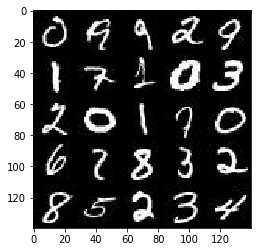

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

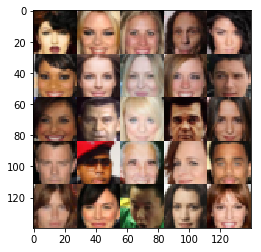

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    images     = tf.placeholder(tf.float32, [None] + [image_width, image_height, image_channels], name='images')
    embeddings = tf.placeholder(tf.float32, [None] + [z_dim], name='embeddings')
    learn_rate = tf.placeholder(tf.float32, name='learning_rate')

    return images, embeddings, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [26]:
import tensorflow.contrib.slim as slim

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xDIM
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        # x2 = tf.layers.dropout(bn2, rate=0.1, training=True) # Always apply per recommended paper

        relu2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        # x3 = tf.layers.dropout(bn3, rate=0.1, training=True) # Always apply per recommended paper

        relu3 = tf.maximum(alpha * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [40]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    dropout = .1
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
                
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.layers.dropout(x1, rate=dropout, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.layers.dropout(x2, rate=dropout, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
                
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.layers.dropout(x3, rate=dropout, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        x4 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())

        # 28x28xoutput_dim now
        
        out = tf.tanh(x4)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [41]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    images, embeddings, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(images, embeddings, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={images: 2*batch_images, embeddings: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={embeddings: batch_z, images: 2*batch_images, learn_rate: learning_rate})

                # Run g optim twice
                _ = sess.run(g_train_opt, feed_dict={embeddings: batch_z, images: 2*batch_images, learn_rate: learning_rate})

                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({embeddings: batch_z, images: 2*batch_images})
                    train_loss_g = g_loss.eval({embeddings: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, embeddings, data_shape[3], data_image_mode)
                    
                steps += 1
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.2128... Generator Loss: 0.0181


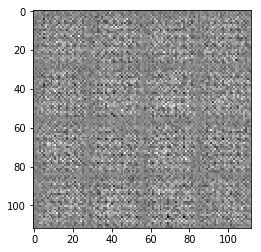

Epoch 1/2... Discriminator Loss: 2.0241... Generator Loss: 0.9058
Epoch 1/2... Discriminator Loss: 1.9996... Generator Loss: 0.2727
Epoch 1/2... Discriminator Loss: 1.4587... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 1.7334... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 1.7719... Generator Loss: 1.2064
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 1.7428... Generator Loss: 0.3381
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 0.4608
Epoch 1/2... Discriminator Loss: 1.4657... Generator Loss: 0.6041
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.7864


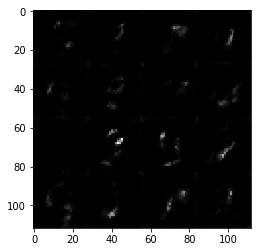

Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 0.8578
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 1.0773
Epoch 1/2... Discriminator Loss: 1.2426... Generator Loss: 0.5219
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 1.2535
Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 1.0308
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 1.3388
Epoch 1/2... Discriminator Loss: 1.2407... Generator Loss: 1.3954
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 0.5863
Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 1.5975... Generator Loss: 0.3699


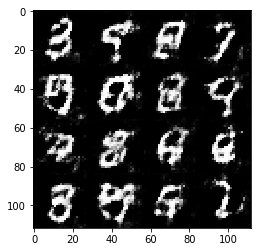

Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.4606
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 1.4396... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 1.5013... Generator Loss: 0.3535
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.4702
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.4281
Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 0.9817
Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 0.6427


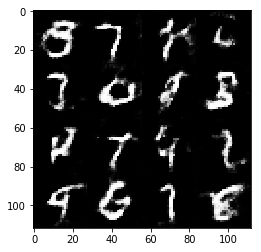

Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 1.1888
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 1.0349... Generator Loss: 0.7721
Epoch 1/2... Discriminator Loss: 1.3386... Generator Loss: 0.4441
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.5597
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 1.3438
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 0.8218
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.4366
Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 0.7490
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 0.7971


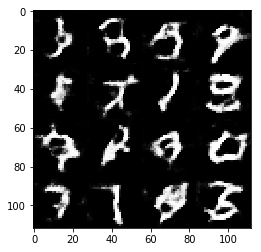

Epoch 1/2... Discriminator Loss: 1.1913... Generator Loss: 0.8838
Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 1.0083
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.4471
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 1.1786
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.5523
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 1.2512... Generator Loss: 1.0994


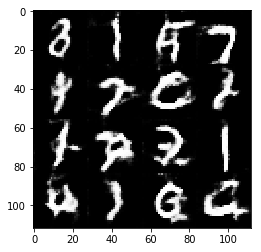

Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 1.6984... Generator Loss: 0.2688
Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 1.0528
Epoch 1/2... Discriminator Loss: 1.4873... Generator Loss: 0.3589
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 0.5535
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.6760
Epoch 1/2... Discriminator Loss: 1.1242... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 1.2922
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 0.9560


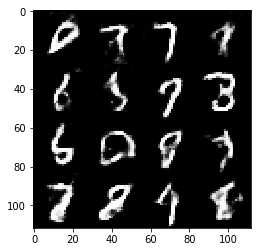

Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 0.5423
Epoch 1/2... Discriminator Loss: 1.1955... Generator Loss: 0.6313
Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.0262... Generator Loss: 1.1908
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.7204
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 0.6885
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 0.4373
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 1.2464
Epoch 1/2... Discriminator Loss: 1.2707... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.8299


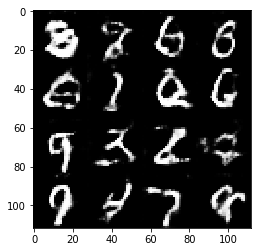

Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 0.5481
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.6170
Epoch 1/2... Discriminator Loss: 0.9919... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.1674... Generator Loss: 1.3168
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.6670
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.4464
Epoch 1/2... Discriminator Loss: 1.1666... Generator Loss: 1.3478
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 0.4574
Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 0.5360


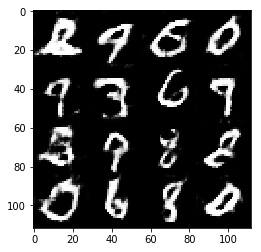

Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 1.6173
Epoch 1/2... Discriminator Loss: 1.0662... Generator Loss: 0.7743
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.5454
Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 0.9903... Generator Loss: 0.8744
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 0.8703
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 0.6569
Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 1.3607


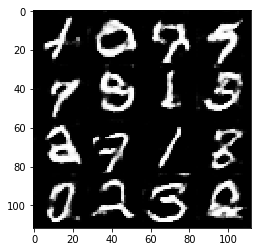

Epoch 1/2... Discriminator Loss: 1.5357... Generator Loss: 0.6251
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.7720
Epoch 1/2... Discriminator Loss: 1.1897... Generator Loss: 0.5971
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.5272
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 0.3555
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 0.6525
Epoch 2/2... Discriminator Loss: 1.3221... Generator Loss: 0.5511
Epoch 2/2... Discriminator Loss: 1.1699... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 0.5828


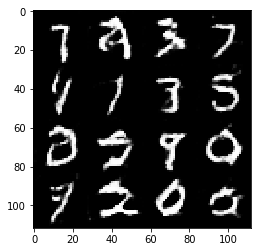

Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 0.7608
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 0.6475
Epoch 2/2... Discriminator Loss: 2.1500... Generator Loss: 0.1981
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 1.0367
Epoch 2/2... Discriminator Loss: 1.0765... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 0.6786
Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 0.7820
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 1.0314... Generator Loss: 1.4101


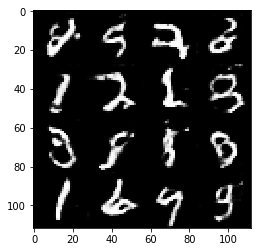

Epoch 2/2... Discriminator Loss: 1.6115... Generator Loss: 0.3115
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 0.9339... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 1.1989
Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.1606
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 1.4930
Epoch 2/2... Discriminator Loss: 1.7974... Generator Loss: 0.2498
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 0.7871
Epoch 2/2... Discriminator Loss: 0.8448... Generator Loss: 1.2031
Epoch 2/2... Discriminator Loss: 0.8257... Generator Loss: 1.2116


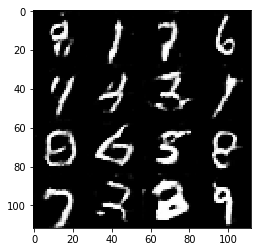

Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 0.5569
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 1.0673... Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 0.7601... Generator Loss: 1.2540
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 1.1766
Epoch 2/2... Discriminator Loss: 1.6348... Generator Loss: 0.3238
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.8218
Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 1.2753
Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 0.6761


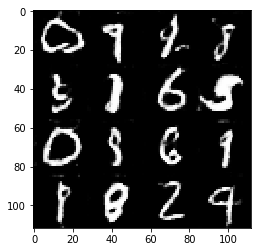

Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 1.0955
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.4190
Epoch 2/2... Discriminator Loss: 0.9796... Generator Loss: 0.8211
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 0.6187
Epoch 2/2... Discriminator Loss: 1.0368... Generator Loss: 0.9463
Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 1.7948
Epoch 2/2... Discriminator Loss: 1.0024... Generator Loss: 0.7295
Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 1.6430
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.5420


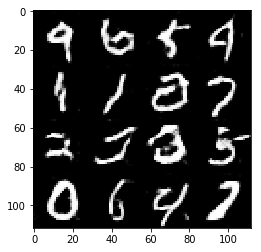

Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 1.4734
Epoch 2/2... Discriminator Loss: 0.8367... Generator Loss: 1.1831
Epoch 2/2... Discriminator Loss: 0.7754... Generator Loss: 1.0359
Epoch 2/2... Discriminator Loss: 0.9176... Generator Loss: 1.8054
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 1.0766
Epoch 2/2... Discriminator Loss: 0.8344... Generator Loss: 0.9244
Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 0.7856
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 0.4858
Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 1.0214


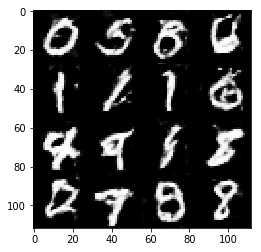

Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 1.0045... Generator Loss: 1.0849
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 0.7408
Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 0.4924
Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 0.7337... Generator Loss: 1.3063
Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 0.5532
Epoch 2/2... Discriminator Loss: 0.7935... Generator Loss: 1.0831
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 1.6508
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 0.8917


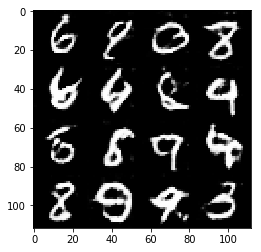

Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.3156
Epoch 2/2... Discriminator Loss: 1.0909... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 0.8291... Generator Loss: 1.2789
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 0.9754
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 0.6603
Epoch 2/2... Discriminator Loss: 0.7206... Generator Loss: 1.0007


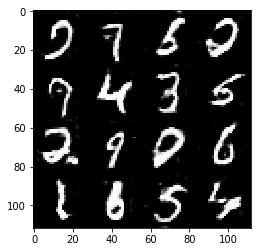

Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 0.7972
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.0442
Epoch 2/2... Discriminator Loss: 1.0826... Generator Loss: 0.6397
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 0.5256
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 0.9967
Epoch 2/2... Discriminator Loss: 1.4467... Generator Loss: 0.3530
Epoch 2/2... Discriminator Loss: 0.9794... Generator Loss: 0.6837


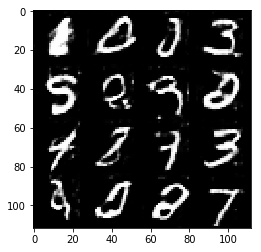

Epoch 2/2... Discriminator Loss: 0.6620... Generator Loss: 1.2552
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 0.6944... Generator Loss: 0.9796
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 0.6613
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 1.5557
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 2.2925


In [45]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.4835... Generator Loss: 0.0458


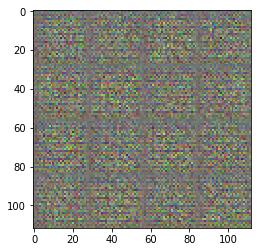

Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 1.4799
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.6380
Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 1.9297
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 2.1623


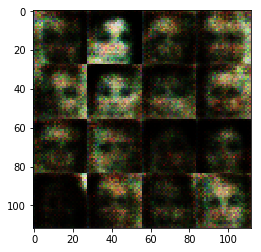

Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 1.7823
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 1.8054
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.7421
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 2.0956


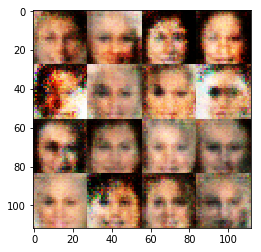

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.4860
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 2.1467
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.3492
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 1.4749
Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 0.3337
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 1.3599


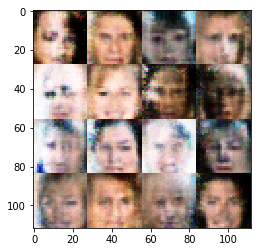

Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 1.2168
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 1.6473
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.8442... Generator Loss: 0.3547
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.4357
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.4480


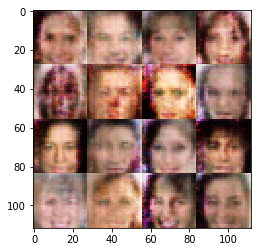

Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.5379


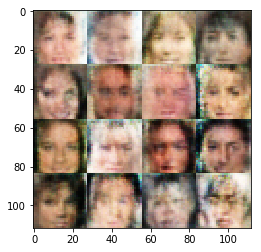

Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6805


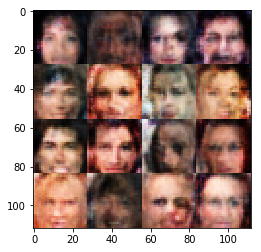

Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7397


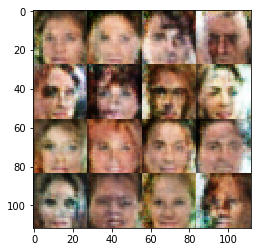

Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6712


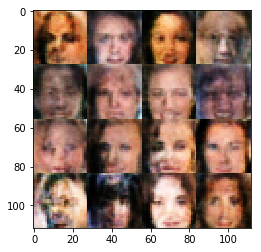

Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6284


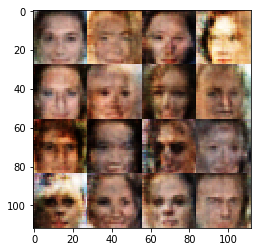

Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7556


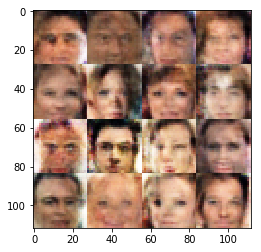

Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6291


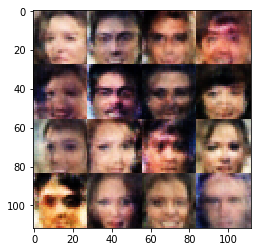

Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.6908


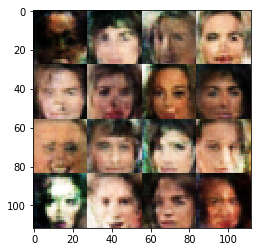

Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6447


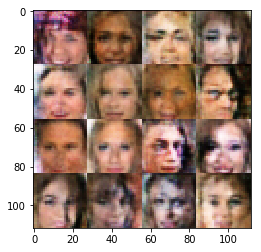

Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.6185... Generator Loss: 0.4846


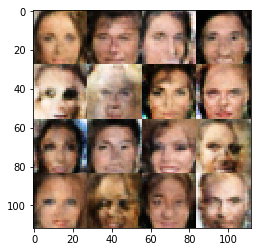

Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6298


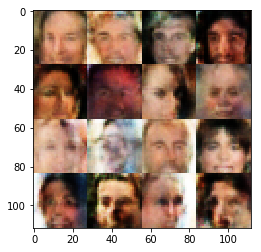

Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.4931


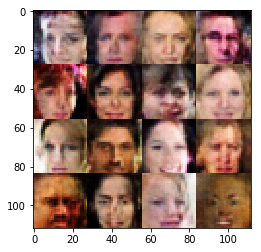

Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6217


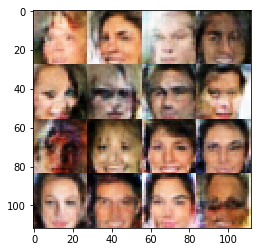

Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7248


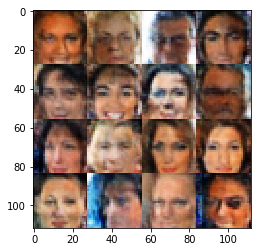

Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.5846... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7117


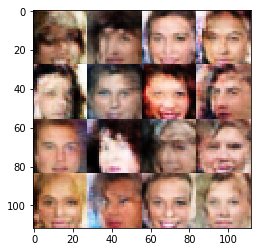

Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.4671


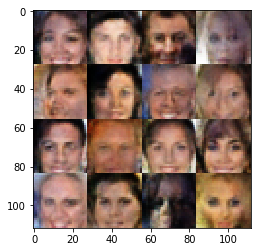

Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.7026... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.5615


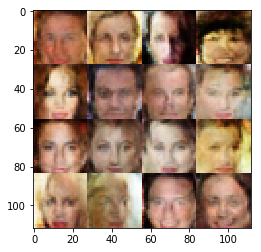

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.5290
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.5677


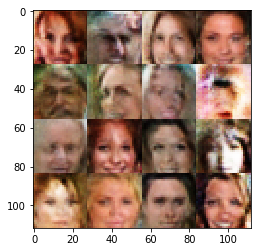

Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6674


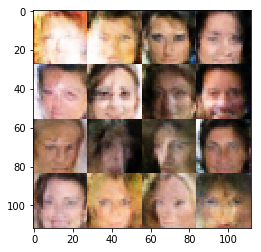

Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6236


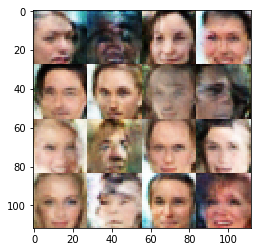

Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.5511


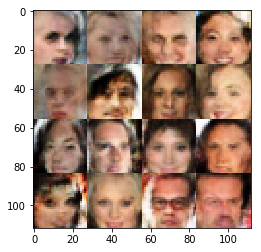

Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6577


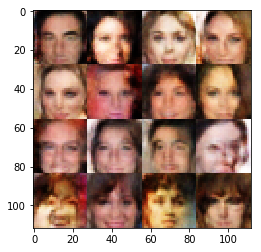

Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.5744


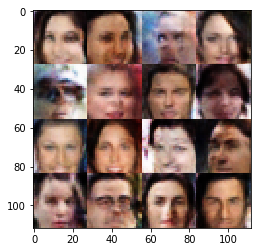

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6038


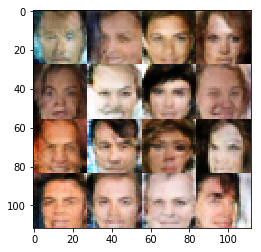

Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.5781


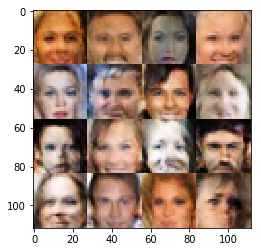

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6034


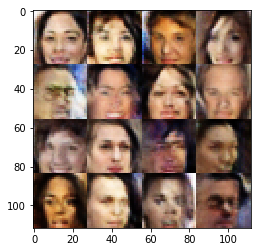

Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.5441
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.5756


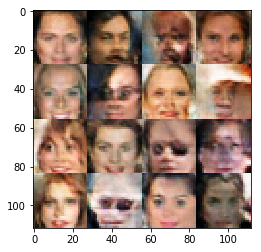

Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6229


In [46]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.